# process apres kis2

1. run part A of this to get metadata
2. run matlab script paper_meltrates
3. run part B of this scribt


Hi Arran,

I've copied the 20/21 traverse data here:

/Volumes/arc_04/FIELD_DATA/K8622021/

Looks like metadata is in KIS\ Science/KIS_science.shp

Looks like the winter over station did well. Have a look at the point measurements when you get a chance and see if everything you are expecting is there.

On his own initiative all the stations were visited with the UC system. I'm hoping this doesn't cause any issues.

Cheers - Huw

# Part A

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
import rasterio as rio
from shapely.geometry import Point, LineString, Polygon, MultiPoint, box
import fiona
from shapely.ops import nearest_points
import matplotlib as mpl
from scipy import interpolate


In [3]:
!ls /Volumes/arc_04/FIELD_DATA/K8622021/'KIS Science'/

'ApRES data files'
 ApRES_RESOURCES
 K862_2021_ShapeFiles
 K862A_2021_TraverseScience-compressed.pdf
'KIS2 New ApRES Trial Sub burst results'
'KIS2 WO GPS copy'
 KIS_science.cpg
 KIS_science.dbf
 KIS_science.prj
 KIS_science.qpj
 KIS_science.shp
 KIS_science.shx
'KSI1 Winterover ApRES Trial subburst.docx'


In [492]:
#read 2020-21 metadata
metadata2021 = gpd.read_file("/Volumes/arc_04/FIELD_DATA/K8622021/KIS Science/KIS_science.shp")


In [493]:
missing_survey = gpd.GeoDataFrame(pd.DataFrame({'id':77, 'Date':'2020-12-23', 'Uni_Event':'VUW', 'Data_type':"ApRES",
        'Depth_m':629, 'Site_ID':"CP12", 'Project':'KIS2', 'Notes':'Arran added this survey metadata, it was missing from KIS_science.shp',
       'ApRes_Unit':'UC Antenna, UC ApRES SN-143', 'File_Name':'Survey_2020-12-23_023455.dat', 'Y':-82.461778, 'X':-152.462687}, index=[77]),geometry=[Point(-152.462687,-82.461778)])

In [494]:
metadata2021 = metadata2021.append(missing_survey).copy()

In [495]:
metadata2021.query('(Data_type=="ApRES") & (Project=="KIS2")',inplace=True)

In [496]:
metadata2021.Site_ID.unique()

array(['Cp34', 'Cp33', 'Cp32', 'Cp31', 'Cp30', 'Cp_29_drill', 'Cp28',
       'Cp27', 'Cp26', 'CP25', 'CP24', 'CP23', 'Cp22', 'CP21', 'CP20',
       'CP19', 'CP15', 'CP18', 'CP16', 'Cp17', 'CP11', 'CP10', 'CP09',
       'CP08', 'CP13', 'CP000007', 'CP14', 'CP06', 'CP05', 'CP04', 'CP01',
       'CP02', 'CP03', 'CP12'], dtype=object)

In [497]:
metadata2021.drop(columns=['id', 'Uni_Event', 'Data_type',
       'Flag1ht_cm', 'Flag2ht_cm',  'Project'], 
             inplace=True)

In [498]:
metadata2021.keys()

Index(['Date', 'AF_Gain', 'Burst', 'RF_Atten', 'Depth_m', 'Site_ID', 'Notes',
       'ApRes_Unit', 'File_Name', 'Y', 'X', 'geometry'],
      dtype='object')

In [499]:
metadata2021.rename(columns={"X":"lon","Y":"lat",'Burst':"Stacks","ApRes_Unit":"APRES_unit","Depth_m":"Approx_Depth"},inplace=True)

In [500]:
metadata2021['Epoch'] = 3
metadata2021['utc_time'] = np.nan

In [501]:
metadata2021['Site_ID'] = metadata2021.Site_ID.apply(lambda x: x.upper()).copy()

In [502]:
metadata2021.drop(columns=['geometry'],inplace=True)

In [503]:
metadata2021.head()

,Date,AF_Gain,Stacks,RF_Atten,Approx_Depth,Site_ID,Notes,APRES_unit,File_Name,lat,lon,Epoch,utc_time
35,2020-12-22,-4,64.0,20,770.0,CP34,F1=W. New site,"UC Antenna, UC unit SN-143",Survey_2020-12-22_035737.dat,-82.471847,-152.208053,3,NaN
36,2020-12-22,-4,64.0,21,665.0,CP33,"F1=W. Two sharp reflectors at 665m and 764m, s...","UC Antenna, UC unit SN-143",Survey_2020-12-22_042049.dat,-82.471548,-152.224309,3,NaN
37,2020-12-22,-4,64.0,20,566.0,CP32,"F1=W. Two sharp reflectors at 566m 765m, new site","UC Antenna, UC unit SN-143",Survey_2020-12-22_044149.dat,-82.471325,-152.238891,3,NaN
38,2020-12-22,-4,64.0,20,493.0,CP31,"F1=W. Two sharp reflectors at 493m, 758m , new...","UC Antenna, UC unit SN-143",Survey_2020-12-22_050111.dat,-82.471154,-152.257888,3,NaN
39,2020-12-22,-4,64.0,24,447.0,CP30,"F1=W, new site, sharp reflectors at 447m and 750m","UC Antenna, UC unit SN-143",Survey_2020-12-22_052753.dat,-82.471072,-152.278526,3,NaN


In [504]:
metadata2021.Site_ID.unique()

array(['CP34', 'CP33', 'CP32', 'CP31', 'CP30', 'CP_29_DRILL', 'CP28',
       'CP27', 'CP26', 'CP25', 'CP24', 'CP23', 'CP22', 'CP21', 'CP20',
       'CP19', 'CP15', 'CP18', 'CP16', 'CP17', 'CP11', 'CP10', 'CP09',
       'CP08', 'CP13', 'CP000007', 'CP14', 'CP06', 'CP05', 'CP04', 'CP01',
       'CP02', 'CP03', 'CP12'], dtype=object)

In [517]:
metadata2021.query('Site_ID == "CP12"')

,Date,AF_Gain,Stacks,RF_Atten,Approx_Depth,Site_ID,Notes,APRES_unit,File_Name,lat,lon,Epoch,utc_time
77,2020-12-23,NaN,NaN,NaN,629.0,CP12,"Arran added this survey metadata, it was missi...","UC Antenna, UC ApRES SN-143",Survey_2020-12-23_023455.dat,-82.461778,-152.462687,3,NaN


In [518]:
metadata1920 = pd.read_csv("/Users/home/whitefar/DATA/ApRES/K862A1920ApRESSites_KIS2.csv")
metadata1920.keys()

Index(['SiteName', 'YYYYUTC', 'MTUTC', 'DDUTC', 'HHUTC', 'MNUTC', 'LATDD',
       'LATMM', 'LONDD', 'LONMM', 'FILE', 'Atten', 'Gain', 'Stacks', 'Epoch',
       'ApproxDepth', 'checked', 'comments'],
      dtype='object')

In [519]:
metadata1920['utc_datetime'] = pd.to_datetime({'year':metadata1920.YYYYUTC,
                           'month':metadata1920.MTUTC,
                            'day':metadata1920.DDUTC,
                               'hour':metadata1920.HHUTC,
                            'minute':metadata1920.MNUTC}).apply(lambda x: pd.Timestamp(x))

In [520]:
metadata1920['utc_time'] = metadata1920['utc_datetime'].apply(lambda x: x.isoformat())
metadata1920['Date'] =metadata1920['utc_datetime'].apply(lambda x: x.date())

In [521]:
metadata1920['lat'] = (metadata1920.LATDD - metadata1920.LATMM/60).round(decimals=6)
metadata1920['lon'] = (metadata1920.LONDD - metadata1920.LONMM/60).round(decimals=6)

In [522]:
metadata1920['APRES_unit'] = 'Huws_unit1'

In [523]:
metadata1920.rename(columns={"SiteName":"Site_ID","FILE":"File_Name","Gain":"AF_Gain","Atten":"RF_Atten","ApproxDepth":"Approx_Depth","comments":"Notes"},inplace=True)

In [524]:
metadata1920.drop(columns=['utc_datetime'],inplace=True)

In [525]:
metadata1920 = metadata1920[metadata2021.keys()].copy()

In [527]:
meta_out = pd.concat([metadata1920,metadata2021])

In [528]:
meta_out.query('Site_ID == "CP12"')

,Date,AF_Gain,Stacks,RF_Atten,Approx_Depth,Site_ID,Notes,APRES_unit,File_Name,lat,lon,Epoch,utc_time
11,2019-12-08,-4,64.0,20,628.0,CP12,NaN,Huws_unit1,2019-12-08_022603.dat,-82.461778,-152.462687,1,2019-12-08T02:35:00
26,2019-12-22,-4,64.0,20,628.0,CP12,NaN,Huws_unit1,2019-12-22_020319.dat,-82.461778,-152.462687,2,2019-12-22T02:12:00
77,2020-12-23,NaN,NaN,NaN,629.0,CP12,"Arran added this survey metadata, it was missi...","UC Antenna, UC ApRES SN-143",Survey_2020-12-23_023455.dat,-82.461778,-152.462687,3,NaN


In [529]:
# meta_out.drop([40],inplace=True)

In [530]:
meta_out.reset_index(drop=True,inplace=True)

In [531]:
meta_out.keys()

Index(['Date', 'AF_Gain', 'Stacks', 'RF_Atten', 'Approx_Depth', 'Site_ID',
       'Notes', 'APRES_unit', 'File_Name', 'lat', 'lon', 'Epoch', 'utc_time'],
      dtype='object')

In [532]:
meta_out = meta_out[['Date', 'utc_time', 'lat', 'lon','Approx_Depth','File_Name','AF_Gain', 'Stacks', 'RF_Atten',  'Site_ID',
       'Notes', 'APRES_unit',   'Epoch']]


In [533]:
# Fix two dud rows

In [534]:
meta_out.Site_ID.replace('CP000007','CP07',inplace=True)

In [535]:
note = 'This site was the original the Original Winter Over ApRES site, possibly where surface measurement was taken before instrument was burried'
meta_out.loc[meta_out.Notes==note,'File_Name'] = 'DATA2020-12-22-1917.DAT'
meta_out.loc[meta_out.Notes==note,['Site_ID','Epoch','File_Name']]

,Site_ID,Epoch,File_Name
66,CP14,3,DATA2020-12-22-1917.DAT


In [536]:
meta_out.to_csv('/Users/home/whitefar/DATA/ApRES/kis2_apres_metadata2021.csv')

In [537]:
meta_out.Site_ID.unique()

array(['CP01', 'CP02', 'CP03', 'CP04', 'CP05', 'CP06', 'CP07', 'CP08',
       'CP09', 'CP10', 'CP11', 'CP12', 'CP13', 'CP14', 'CP15', 'CP16',
       'CP17', 'CP18', 'CP19', 'CP20', 'CP21', 'CP22', 'CP23', 'CP24',
       'CP25', 'CP34', 'CP33', 'CP32', 'CP31', 'CP30', 'CP_29_DRILL',
       'CP28', 'CP27', 'CP26'], dtype=object)

In [538]:
meta_out.query('Site_ID == "CP12"')

,Date,utc_time,lat,lon,Approx_Depth,File_Name,AF_Gain,Stacks,RF_Atten,Site_ID,Notes,APRES_unit,Epoch
11,2019-12-08,2019-12-08T02:35:00,-82.461778,-152.462687,628.0,2019-12-08_022603.dat,-4,64.0,20,CP12,NaN,Huws_unit1,1
26,2019-12-22,2019-12-22T02:12:00,-82.461778,-152.462687,628.0,2019-12-22_020319.dat,-4,64.0,20,CP12,NaN,Huws_unit1,2
73,2020-12-23,NaN,-82.461778,-152.462687,629.0,Survey_2020-12-23_023455.dat,NaN,NaN,NaN,CP12,"Arran added this survey metadata, it was missi...","UC Antenna, UC ApRES SN-143",3


In [539]:
meta_out.sort_values(by=['Site_ID','Epoch'],inplace=True)

In [540]:
meta_out.reset_index(drop=True,inplace=True)

In [541]:
meta_out.to_csv('/Users/home/whitefar/DATA/ApRES/kis2_apres_metadata_by_Site_ID.csv')

### NOW PROCESS IN MATLAB WITH paper_meltrates.m

# Part B

In [542]:
!ls /Volumes/arc_04/FIELD_DATA/K8622021/'KIS Science'/'ApRES data files'/KIS2

 DATA2020-12-22-1917.DAT        Survey_2020-12-23_001015.dat
'KIS2 Old WO ApRES Card1'       Survey_2020-12-23_002658.dat
'KIS2 Old WO ApRES Card2'       Survey_2020-12-23_004352.dat
 Survey_2020-12-22_035737.dat   Survey_2020-12-23_010317.dat
 Survey_2020-12-22_042049.dat   Survey_2020-12-23_013605.dat
 Survey_2020-12-22_044149.dat   Survey_2020-12-23_015608.dat
 Survey_2020-12-22_050111.dat   Survey_2020-12-23_021900.dat
 Survey_2020-12-22_052753.dat   Survey_2020-12-23_023455.dat
 Survey_2020-12-22_201557.dat   Survey_2020-12-23_024953.dat
 Survey_2020-12-22_203746.dat   Survey_2020-12-23_030547.dat
 Survey_2020-12-22_205751.dat   Survey_2020-12-23_042754.dat
 Survey_2020-12-22_211915.dat   Survey_2020-12-23_045043.dat
 Survey_2020-12-22_213835.dat   Survey_2020-12-23_050820.dat
 Survey_2020-12-22_221342.dat   Survey_2020-12-23_052812.dat
 Survey_2020-12-22_223029.dat   Survey_2020-12-23_202213.dat
 Survey_2020-12-22_224858.dat   Survey_2020-12-23_204021.dat
 Survey_2020-12-22_23040

In [543]:
meta_out.keys()

Index(['Date', 'utc_time', 'lat', 'lon', 'Approx_Depth', 'File_Name',
       'AF_Gain', 'Stacks', 'RF_Atten', 'Site_ID', 'Notes', 'APRES_unit',
       'Epoch'],
      dtype='object')

In [544]:
# Load from matlab

In [36]:
melt_rates = pd.read_csv('/Users/home/whitefar/DATA/ApRES/kis2_meltrates_matlab.csv')
melt_rates.keys()

Index(['Var1', 'Date', 'utc_time', 'lat', 'lon', 'Approx_Depth', 'File_Name',
       'AF_Gain', 'Stacks', 'RF_Atten', 'Site_ID', 'Notes', 'APRES_unit',
       'Epoch', 'meltRate', 'meltRateError', 'bed', 'dhStrain', 'dheStrain'],
      dtype='object')

In [37]:
# MISSING CP12 epoch 3
melt_rates.query('Site_ID == "CP12"').Epoch

33    1
34    2
35    3
Name: Epoch, dtype: int64

In [38]:
# df.loc[df['column_name'].isin(some_values)]
downchannel = ['CP15','CP16', 'CP17', 'CP18', 'CP19', 'CP20', 'CP21', 'CP22', 'CP23', 'CP24','CP25' ]

crosschannel = ['CP01', 'CP02', 'CP03', 'CP04', 'CP05', 'CP06', 'CP07', 'CP08',
       'CP09', 'CP10', 'CP11', 'CP12', 'CP13', 'CP14', 'CP15' ]


In [39]:
melt_rates['cross_channel'] = melt_rates['Site_ID'].isin(crosschannel)
melt_rates['down_channel'] = melt_rates['Site_ID'].isin(downchannel)

In [40]:
# melt_rates = melt_rates.query('Epoch == 3').copy()

In [41]:
points = [Point(xy) for xy in zip(melt_rates.lon,melt_rates.lat) ]
gdf = gpd.GeoDataFrame(melt_rates,geometry=points,crs=4326)

In [42]:
gd = gdf.to_crs(3031)
gd['x']=gd.geometry.x
gd['y']=gd.geometry.y

In [43]:
!ls /Users/home/whitefar/DATA/ApRES/

Depth_or_range_melt_calculation.csv  kis2_apres_metadata.csv
K862A1920ApRESSites_KIS2.csv	     kis2_meltrates.csv
kis2_apres_metadata2021.csv	     kis2_meltrates_matlab.csv
kis2_apres_metadata_by_Site_ID.csv


In [44]:
#can just use the bed
# depth_guess_used = pd.read_csv('/Users/home/whitefar/DATA/ApRES/Depth_or_range_melt_calculation.csv')
# # depth_guess_used
# gd['Depth_or_range_melt_calculation'] = depth_guess_used

In [45]:
Site_ID_not_repeated = ['CP26', 'CP27', 'CP28', 'CP30', 'CP31', 'CP32', 'CP33',
       'CP34', 'CP_29_DRILL']

In [46]:
gd.drop(gd.index[gd['Site_ID'].isin(Site_ID_not_repeated)],inplace=True)

In [47]:
# gd.rename(columns={"meltRate":"meltRate_v_Epoch1"},inplace=True)
gd["meltRate_v_Epoch1"] = gd.meltRate

In [48]:
res_bed_cross = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp').query('line_name == "lineAPREScross"')
res_bed_down = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp').query('line_name == "lineAPRESdown"')                                                                                                              
                                                                                                              

In [49]:
fresbedcross = interpolate.interp1d(res_bed_cross.x,res_bed_cross.ice_thickn)
gd.loc[gd.query('cross_channel').index,'migrated_res_thickness_at_apres_sites'] = fresbedcross(gd.query('cross_channel').x-15)

In [50]:
gd.drop(columns=['geometry','Var1']).to_csv('/Users/home/whitefar/DATA/ApRES/kis2_meltrates.csv',index=False)

# Find migrated depth from res radar

In [ ]:
# look for missing CP12

In [417]:
meta

array(['Survey_2020-12-22_035737.dat', 'Survey_2020-12-22_042049.dat',
       'Survey_2020-12-22_044149.dat', 'Survey_2020-12-22_050111.dat',
       'Survey_2020-12-22_052753.dat', 'Survey_2020-12-22_201557.dat',
       'Survey_2020-12-22_203746.dat', 'Survey_2020-12-22_205751.dat',
       'Survey_2020-12-22_211915.dat', 'Survey_2020-12-22_213835.dat',
       'Survey_2020-12-22_221342.dat', 'Survey_2020-12-22_223029.dat',
       'Survey_2020-12-22_224858.dat', 'Survey_2020-12-22_230405.dat',
       'Survey_2020-12-22_233240.dat', 'Survey_2020-12-22_234900.dat',
       'Survey_2020-12-23_001015.dat', 'Survey_2020-12-23_002658.dat',
       'Survey_2020-12-23_004352.dat', 'Survey_2020-12-23_010317.dat',
       'Survey_2020-12-23_013605.dat', 'Survey_2020-12-23_015608.dat',
       'Survey_2020-12-23_021900.dat', 'Survey_2020-12-23_024953.dat',
       'Survey_2020-12-23_030547.dat', 'Survey_2020-12-23_042754.dat',
       None, 'Survey_2020-12-23_045043.dat',
       'Survey_2020-12-23_050820

In [424]:
files = [os.path.basename(f) for f in glob.glob('/Volumes/arc_04/FIELD_DATA/K8622021/KIS Science/ApRES data files/KIS2/Survey_2020*')]
meta = metadata2021.File_Name.to_numpy()
[(f,np.argwhere(meta==f)) for f in files]

[('Survey_2020-12-22_211915.dat', array([[8]])),
 ('Survey_2020-12-23_001015.dat', array([[16]])),
 ('Survey_2020-12-22_230405.dat', array([[13]])),
 ('Survey_2020-12-22_042049.dat', array([[1]])),
 ('Survey_2020-12-22_052753.dat', array([[4]])),
 ('Survey_2020-12-23_030547.dat', array([[24]])),
 ('Survey_2020-12-22_233240.dat', array([[14]])),
 ('Survey_2020-12-23_050820.dat', array([[28]])),
 ('Survey_2020-12-22_213835.dat', array([[9]])),
 ('Survey_2020-12-23_023455.dat', array([], shape=(0, 1), dtype=int64)),
 ('Survey_2020-12-23_002658.dat', array([[17]])),
 ('Survey_2020-12-24_210803.dat', array([], shape=(0, 1), dtype=int64)),
 ('Survey_2020-12-23_052812.dat', array([[29]])),
 ('Survey_2020-12-23_045043.dat', array([[27]])),
 ('Survey_2020-12-22_201557.dat', array([[5]])),
 ('Survey_2020-12-23_004352.dat', array([[18]])),
 ('Survey_2020-12-22_224858.dat', array([[12]])),
 ('Survey_2020-12-22_205751.dat', array([[7]])),
 ('Survey_2020-12-22_203746.dat', array([[6]])),
 ('Survey_2

In [ ]:
# bed is at 629 for Survey_2020-12-23_023455.dat

In [335]:
dc_m= gd.loc[gd['down_channel']==True].copy()
cc_m = gd.loc[gd['cross_channel']==True].copy()

In [387]:
gdp = gd
plt.figure(figsize=(8,8))
plt.scatter(gd.x,gd.y,c=gd.meltRate,cmap='bwr',vmin=-2,vmax=2)
plt.colorbar()
plt.show()

AttributeError: 'GeoDataFrame' object has no attribute 'meltRate'

<Figure size 576x576 with 0 Axes>

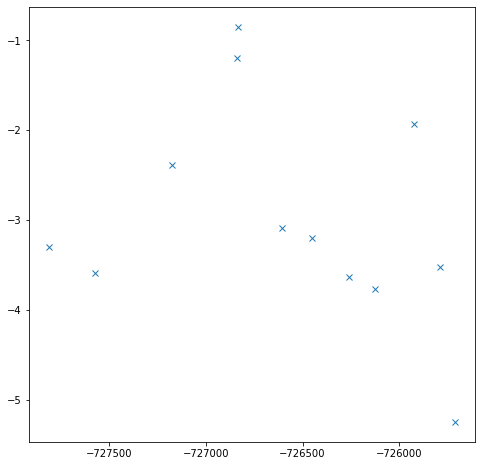

In [337]:
dfp = gd.query('down_channel')
plt.figure(figsize=(8,8))
plt.plot(dfp.y,dfp.meltRate,'x')
# plt.plot(cc_m.loc[melt_rates['Epoch']==2].x,cc_m.loc[melt_rates['Epoch']==2].meltRate,'o')
plt.show()

In [386]:
dfp = gd.query('(Epoch == 2) & cross_channel')
dfp2 = gd.query('(Epoch == 3) & cross_channel')
plt.figure(figsize=(8,8))
plt.plot(dfp.x,dfp.meltRate,'x')
plt.plot(dfp2.x,dfp2.meltRate,'o')
# plt.plot(cc_m.loc[melt_rates['Epoch']==2].x,cc_m.loc[melt_rates['Epoch']==2].meltRate,'o')
plt.show()

AttributeError: 'GeoDataFrame' object has no attribute 'meltRate'

<Figure size 576x576 with 0 Axes>

In [340]:
# plt.figure(figsize=(8,8))
# plt.scatter(melt_rates.lat,melt_rates.lon,c=melt_rates.meltRate,cmap='bwr',vmin=-2,vmax=2)
# for i in range(melt_rates.shape[0]):
#     plt.annotate( melt_rates.iloc[i].Site_ID,(melt_rates.iloc[i].lon, melt_rates.iloc[i].lat),xytext=(melt_rates.iloc[i].lon+0.5, melt_rates.iloc[i].lat+0.5),arrowprops=dict(arrowstyle='->'),fontsize=8)
# # plt.colorbar()
# plt.show()

In [19]:
melt_rates.keys()

Index(['Unnamed: 0', 'Var1', 'Date', 'utc_time', 'lat', 'lon', 'Approx_Depth',
       'File_Name', 'AF_Gain', 'Stacks', 'RF_Atten', 'Site_ID', 'Notes',
       'APRES_unit', 'Epoch', 'meltRate', 'meltRateError', 'bed', 'dhStrain',
       'dheStrain', 'cross_channel', 'down_channel', 'x', 'y', 'geometry'],
      dtype='object')

In [21]:
!mkdir /Volumes/arc_04/FIELD_DATA/KIS2_apres/

In [20]:
melt_rates.File_Name.iloc[0]

'2019-12-07_225600.dat'

In [22]:
import shutil

In [25]:
for file in melt_rates.query('Epoch != 3').File_Name:
    src_file = f'/Volumes/arc_04/FIELD_DATA/K8621920/APRES/Survey_{file}'
    dst_file = f'/Volumes/arc_04/FIELD_DATA/KIS2_apres/Survey_{file}'
    shutil.copyfile(src_file, dst_file)